## I am going to make a Image classification CNN model that is going to try and predict what a bunch of pictures represents. My dataset is the english language
## in sign language. So I have 26 classes A-Z. 

## Lets start by picking a good dataset by inspecting the pictures in both the original state and the preprocessed state.

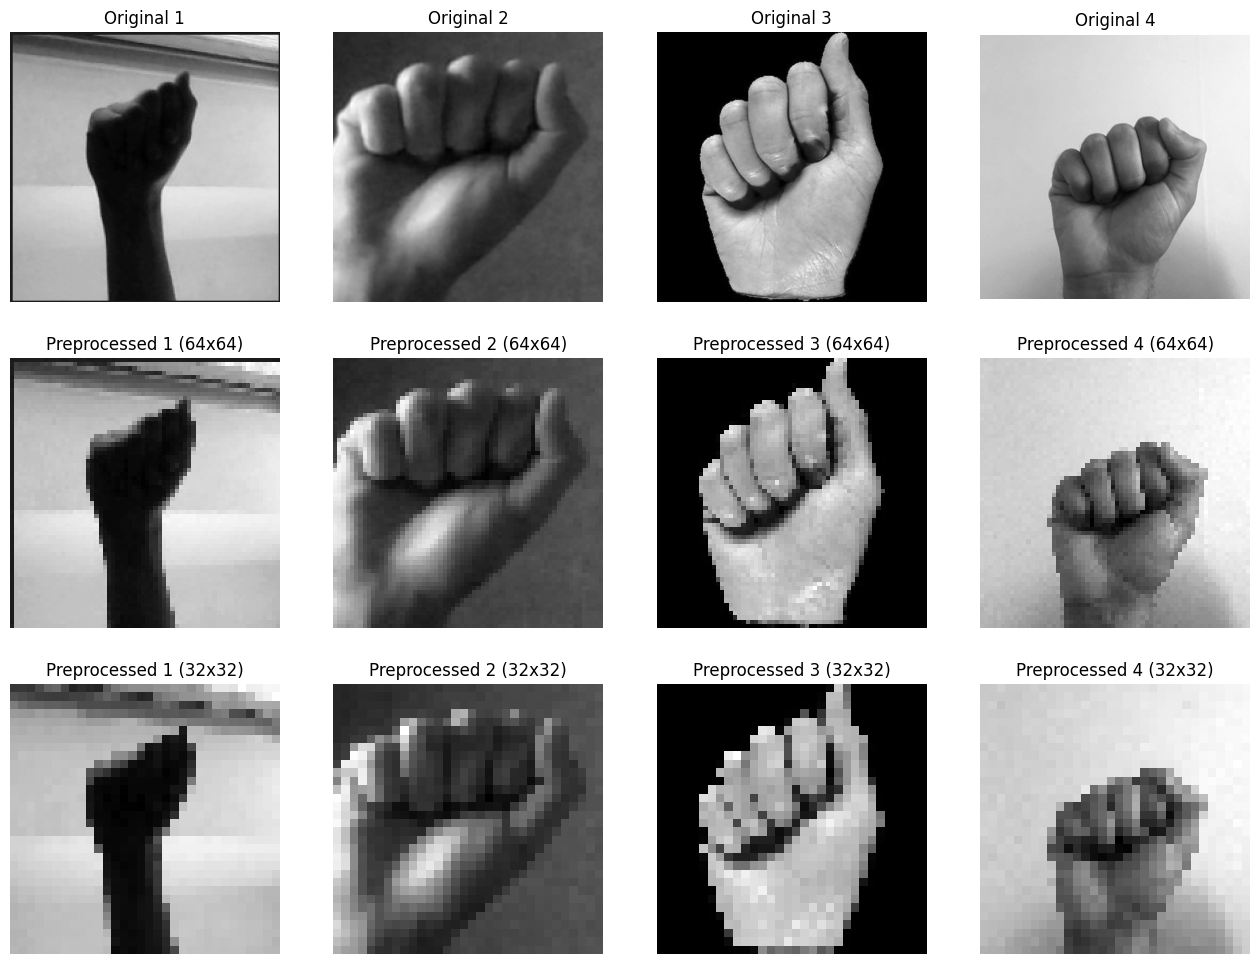

In [139]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

IMG_SIZE = (64, 64)  # Use a tuple for target_size
IMG_SIZE_SMALL = (32, 32)  # New target size for the smaller preprocessed images

# Specify the path to the "Image_choice" directory containing four pictures
IMAGE_CHOICE_PATH = "Image_choice"

# Get a list of image file names in the directory
image_file_names = os.listdir(IMAGE_CHOICE_PATH)

# Create the full paths to the images
image_paths = [os.path.join(IMAGE_CHOICE_PATH, name) for name in image_file_names]

# Function to preprocess an image
def preprocess_image(image_path, target_size):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=target_size, color_mode='grayscale'  # Change color_mode to 'grayscale'
    )
    img = tf.keras.preprocessing.image.img_to_array(img)
    img /= 255.0  # Normalize pixel values to the range [0, 1]
    return img

# Load and preprocess the original images
original_images = [tf.keras.preprocessing.image.load_img(path, color_mode='grayscale') for path in image_paths]
preprocessed_images_64 = [preprocess_image(path, target_size=IMG_SIZE) for path in image_paths]
preprocessed_images_32 = [preprocess_image(path, target_size=IMG_SIZE_SMALL) for path in image_paths]

# Create labels for the images
labels = ["Original 1", "Original 2", "Original 3", "Original 4",
          "Preprocessed 1 (64x64)", "Preprocessed 2 (64x64)", "Preprocessed 3 (64x64)", "Preprocessed 4 (64x64)",
          "Preprocessed 1 (32x32)", "Preprocessed 2 (32x32)", "Preprocessed 3 (32x32)", "Preprocessed 4 (32x32)"]

# Plot the images with labels
plt.figure(figsize=(16, 12))

for i in range(12):
    plt.subplot(3, 4, i + 1)
    if i < 4:
        plt.imshow(original_images[i], cmap='gray')  # Original image
    elif i < 8:
        plt.imshow(preprocessed_images_64[i - 4], cmap='gray')  # Preprocessed image (64x64)
    else:
        plt.imshow(preprocessed_images_32[i - 8], cmap='gray')  # Preprocessed image (32x32)
    plt.title(labels[i])
    plt.axis("off")

plt.show()


The pictures in 32x32 is not that good. They dont have smooth lines around the hand. That is going to be difficult for the CNN to get some good features out of. I think all the pictures with 64x64 looks pretty good. The dataset of the first image is the biggest dataset so I am going to try that and I am also going to try the dataset of the third picture. 

Lets get to it!

# Preprocessing

I am going to use 64x64 pixels.  There is approximately 55 pictures per letter in this dataset
and I am going to divide it into train, test and validation so the result will be 60% training data, 20% validation data and 20% test data. I will use a CNN network 
to look for features in all the letters and then I am going to have all these features as input to my classification layers to try and classify the letter.

In [ ]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

# Define the path to your dataset folder
data_dir = 'Dataset2/asl_dataset'
letters = sorted(os.listdir(data_dir))

# Load and preprocess the images
def load_images(data_dir, letters):
    images = []
    labels = []
    for i, letter in enumerate(letters):
        letter_dir = os.path.join(data_dir, letter)
        for filename in os.listdir(letter_dir):
            img_path = os.path.join(letter_dir, filename)
            img = load_img(img_path, color_mode='grayscale', target_size=(64, 64))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(i)  # Use index as label
    return np.array(images), np.array(labels)

x_data, y_data = load_images(data_dir, letters)

# Normalize pixel values
x_data = x_data.astype(np.float32) / 255

# Convert labels to one-hot encoding
y_data = to_categorical(y_data, len(letters))

# Split the data into training, validation, and test sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

I am going to try without any regluarization, drop out or augmentation. I want three convolutional layers and maxpooling layers. Filter size is going to be 3x3.
Activation function relu and softmax. I am going to use 64 neurons in the first layer, 128 in the second and 256 in the third.

In [78]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(len(letters), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=15, batch_size=64, validation_data=(x_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/15
23/23 [==============================] - 9s 342ms/step - loss: 2.1485 - accuracy: 0.3402 - val_loss: 0.7172 - val_accuracy: 0.7735
Epoch 2/15
23/23 [==============================] - 8s 336ms/step - loss: 0.4995 - accuracy: 0.8299 - val_loss: 0.3801 - val_accuracy: 0.8895
Epoch 3/15
23/23 [==============================] - 8s 340ms/step - loss: 0.1870 - accuracy: 0.9318 - val_loss: 0.1158 - val_accuracy: 0.9558
Epoch 4/15
23/23 [==============================] - 8s 344ms/step - loss: 0.0763 - accuracy: 0.9752 - val_loss: 0.0795 - val_accuracy: 0.9724
Epoch 5/15
23/23 [==============================] - 8s 349ms/step - loss: 0.0416 - accuracy: 0.9862 - val_loss: 0.0831 - val_accuracy: 0.9779
Epoch 6/15
23/23 [==============================] - 8s 354ms/step - loss: 0.0153 - accuracy: 0.9945 - val_loss: 0.1014 - val_accuracy: 0.9779
Epoch 7/15
23/23 [==============================] - 9s 379ms/step - loss: 0.0207 - accuracy: 0.9931 - val_loss: 0.1181 - val_accuracy: 0.9724
Epoch 

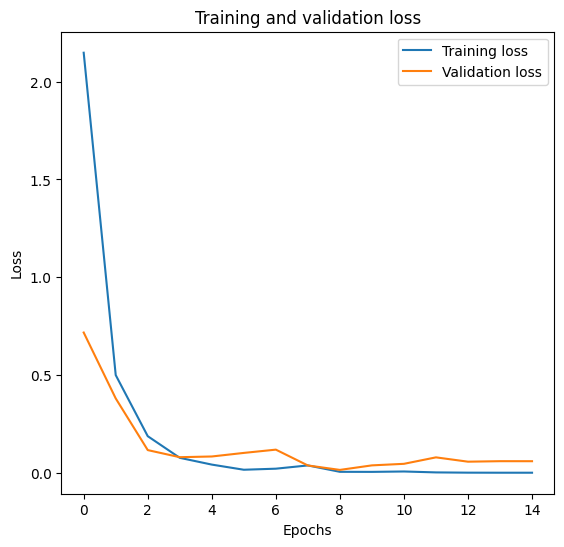

In [79]:
# Plot training and validation loss (same as before)
plt.figure(figsize=(14, 6), facecolor='w')
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The test accuracy looks very good 0.9725274443626404! The plot looks good til the 8th epoch. The Validation loss is increasing after the 8th epoch. 
The training loss cruve is flattening out at the 8th epoch. We can see here at the 9th epoch we got this : loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.0145 - val_accuracy: 0.9945
compared to this at the 15th epoch : loss: 6.4939e-05 - accuracy: 1.0000 - val_loss: 0.0590 - val_accuracy: 0.9890
Maybe we should train another one on 8 epochs and see what happens.
It has no sign of underfitting or overfitting so we dont need any dropout or regularization.

In [80]:
# Build your model with the same architecture
model1 = Sequential()

model1.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model1.add(MaxPooling2D((2, 2)))

model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))

model1.add(Conv2D(256, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))

model1.add(Flatten())

model1.add(Dense(1024, activation='relu'))
model1.add(Dense(512, activation='relu'))
model1.add(Dense(len(letters), activation='softmax'))

# Compile the new model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the new model with 7 epochs
history1 = model1.fit(x_train, y_train, epochs=8, batch_size=64, validation_data=(x_val, y_val))

# Evaluate the new model on the test set
new_test_loss, new_test_accuracy = model1.evaluate(x_test, y_test)
print(f"New Model Test Accuracy: {new_test_accuracy}")

# Save the model

model1.save('model1.h5')


Epoch 1/8
23/23 [==============================] - 9s 361ms/step - loss: 1.9724 - accuracy: 0.4174 - val_loss: 0.7206 - val_accuracy: 0.7790
Epoch 2/8
23/23 [==============================] - 8s 355ms/step - loss: 0.4573 - accuracy: 0.8499 - val_loss: 0.3423 - val_accuracy: 0.8950
Epoch 3/8
23/23 [==============================] - 9s 383ms/step - loss: 0.1930 - accuracy: 0.9346 - val_loss: 0.1030 - val_accuracy: 0.9779
Epoch 4/8
23/23 [==============================] - 8s 350ms/step - loss: 0.0503 - accuracy: 0.9869 - val_loss: 0.1518 - val_accuracy: 0.9337
Epoch 5/8
23/23 [==============================] - 8s 357ms/step - loss: 0.0449 - accuracy: 0.9862 - val_loss: 0.0873 - val_accuracy: 0.9669
Epoch 6/8
23/23 [==============================] - 8s 361ms/step - loss: 0.0501 - accuracy: 0.9876 - val_loss: 0.1676 - val_accuracy: 0.9669
Epoch 7/8
23/23 [==============================] - 9s 394ms/step - loss: 0.0541 - accuracy: 0.9862 - val_loss: 0.0372 - val_accuracy: 0.9834
Epoch 8/8
6/6

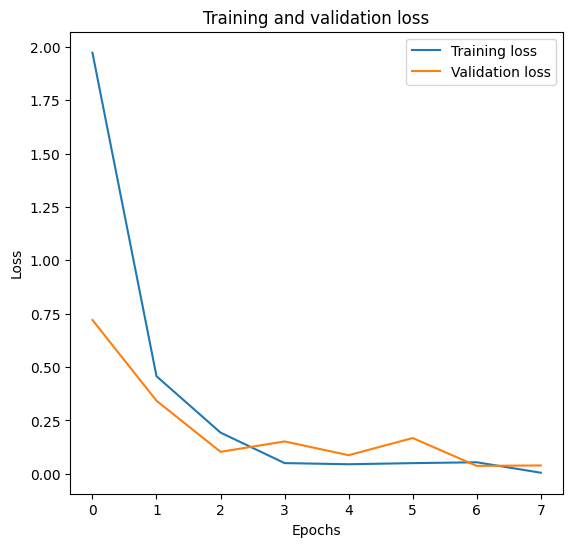

In [81]:
# Plot training and validation loss (same as before)
plt.figure(figsize=(14, 6), facecolor='w')
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Training loss')
plt.plot(history1.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The test accuracy fell but the val loss is following training loss pretty well. 
But these numbers are much better than the last numbers : loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.0393 - val_accuracy: 0.9890
We'll use this model!

1/1 [==============================] - 0s 23ms/step


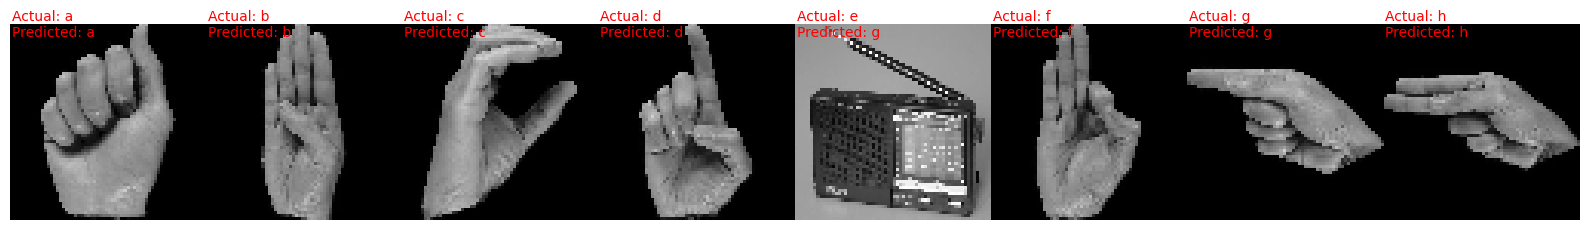

In [85]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def interact_with_user(model, letters):
    image_dir = 'Dataset2/evaluation1'
    class_folders = sorted(os.listdir(image_dir))

    plt.figure(figsize=(16, 4))  # Adjust the figure size as needed for a single row

    image_row = []  # To store images in the current row
    labels = []     # To store labels for images

    for i, folder in enumerate(class_folders):
        class_path = os.path.join(image_dir, folder)
        image_files = os.listdir(class_path)

        for j, image_file in enumerate(image_files):
            image_path = os.path.join(class_path, image_file)

            img = load_img(image_path, color_mode='grayscale', target_size=(64, 64))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            actual_class = folder
            predicted_class = letters[np.argmax(model.predict(img_array))]

            image_row.append(np.squeeze(img_array))
            labels.append(f"Actual: {actual_class}\nPredicted: {predicted_class}")

    # Concatenate the images horizontally
    combined_image = np.concatenate(image_row, axis=1)

    plt.imshow(combined_image, cmap='gray', interpolation='none')
    plt.axis('off')

    # Annotate images with labels above them
    for i, label in enumerate(labels):
        col_idx = i * 64  # Adjust the x-coordinate based on the position within the row
        plt.text(col_idx, -5, label, fontsize=10, color='red', verticalalignment='top')

    plt.tight_layout()
    plt.show()

# Interact with the user and display all images in a single row with labels
interact_with_user(model1, letters)


This looks good. I just put the radio there to double check that the model just made its predictions on to the classes based on the folder names.

1/1 [==============================] - 0s 20ms/step


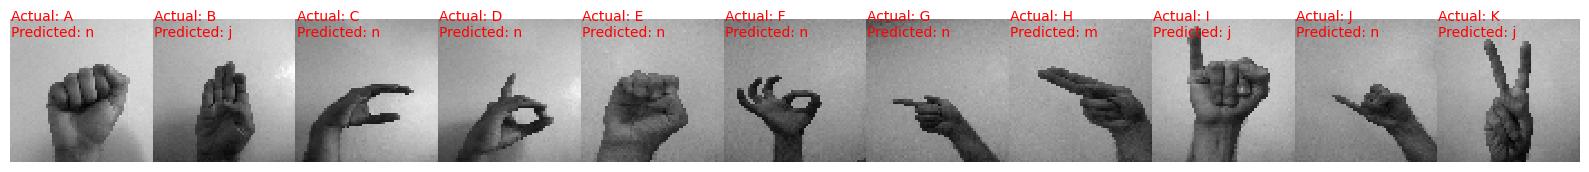

In [88]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def interact_with_user(model, letters):
    image_dir = 'Dataset2/evaluation2'
    class_folders = sorted(os.listdir(image_dir))

    plt.figure(figsize=(16, 4))  # Adjust the figure size as needed for a single row

    image_row = []  # To store images in the current row
    labels = []     # To store labels for images

    for i, folder in enumerate(class_folders):
        class_path = os.path.join(image_dir, folder)
        image_files = os.listdir(class_path)

        for j, image_file in enumerate(image_files):
            image_path = os.path.join(class_path, image_file)

            img = load_img(image_path, color_mode='grayscale', target_size=(64, 64))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            actual_class = folder
            predicted_class = letters[np.argmax(model.predict(img_array))]

            image_row.append(np.squeeze(img_array))
            labels.append(f"Actual: {actual_class}\nPredicted: {predicted_class}")

    # Concatenate the images horizontally
    combined_image = np.concatenate(image_row, axis=1)

    plt.imshow(combined_image, cmap='gray', interpolation='none')
    plt.axis('off')

    # Annotate images with labels above them
    for i, label in enumerate(labels):
        col_idx = i * 64  # Adjust the x-coordinate based on the position within the row
        plt.text(col_idx, -5, label, fontsize=10, color='red', verticalalignment='top')

    plt.tight_layout()
    plt.show()

# Interact with the user and display all images in a single row with labels
interact_with_user(model1, letters)


This is predictions on my own photographs. Not a single right answer and for some reason it wants to predict class "n" very often.

Summary :

The accuracy and loss plots looks good. The test accuracy is very good. The model is not overfitting or underfitting but the predictions on my pictures are
not good. Not even one of them is right. Maybe i need som more training data or maybe some augmentation on my pictures. 
I am going to try the other dataset to try and make a better model. I am going to use the same model architecture, same parameters and preprocessing and see what happens.
This new dataset also has A-Z classes but it has 3000 pictures of each of the letters. So now we have 60 times more data than the last dataset.
Lets get to it!

In [90]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

# Define the path to your dataset folder
data_dir = 'Dataset/sign_train'
letters = sorted(os.listdir(data_dir))

# Load and preprocess the images
def load_images(data_dir, letters):
    images = []
    labels = []
    for i, letter in enumerate(letters):
        letter_dir = os.path.join(data_dir, letter)
        for filename in os.listdir(letter_dir):
            img_path = os.path.join(letter_dir, filename)
            img = load_img(img_path, color_mode='grayscale', target_size=(64, 64))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(i)  # Use index as label
    return np.array(images), np.array(labels)

x_data, y_data = load_images(data_dir, letters)

# Normalize pixel values
x_data = x_data.astype(np.float32) / 255

# Convert labels to one-hot encoding
y_data = to_categorical(y_data, len(letters))

# Split the data into training, validation, and test sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

# Build your model as before
model2 = Sequential()

model2.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))

model2.add(Flatten())

model2.add(Dense(1024, activation='relu'))
model2.add(Dense(512, activation='relu'))
model2.add(Dense(len(letters), activation='softmax'))

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Lets start with 10 epochs and see what happens.

In [93]:
# Train the model
history2 = model2.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_val, y_val))

# Save the model

model2.save('model2.h5')

Epoch 1/10
975/975 [==============================] - 385s 395ms/step - loss: 0.5806 - accuracy: 0.8095 - val_loss: 0.1098 - val_accuracy: 0.9653
Epoch 2/10
975/975 [==============================] - 400s 410ms/step - loss: 0.0741 - accuracy: 0.9759 - val_loss: 0.0875 - val_accuracy: 0.9738
Epoch 3/10
975/975 [==============================] - 380s 390ms/step - loss: 0.0494 - accuracy: 0.9850 - val_loss: 0.0456 - val_accuracy: 0.9917
Epoch 4/10
975/975 [==============================] - 375s 385ms/step - loss: 0.0329 - accuracy: 0.9904 - val_loss: 0.0312 - val_accuracy: 0.9895
Epoch 5/10
975/975 [==============================] - 376s 385ms/step - loss: 0.0263 - accuracy: 0.9925 - val_loss: 0.0170 - val_accuracy: 0.9949
Epoch 6/10
975/975 [==============================] - 376s 386ms/step - loss: 0.0298 - accuracy: 0.9921 - val_loss: 0.0097 - val_accuracy: 0.9982
Epoch 7/10
975/975 [==============================] - 376s 386ms/step - loss: 0.0151 - accuracy: 0.9958 - val_loss: 0.0349 -

c:\Users\Ronny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [101]:
# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

244/244 [==============================] - 13s 52ms/step - loss: 0.0934 - accuracy: 0.9738
Test Accuracy: 0.9738461375236511


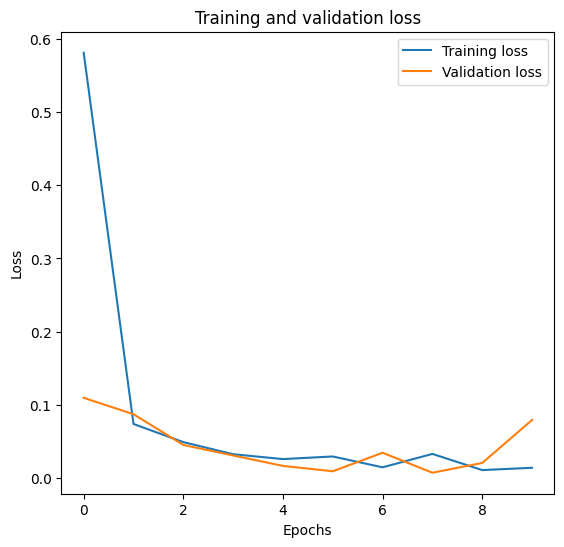

In [96]:
# Plot training and validation loss (same as before)
plt.figure(figsize=(14, 6), facecolor='w')
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test Accuracy: 0.9738461375236511

This looks really good. loss: 0.0144 - accuracy: 0.9964 - val_loss: 0.0796 - val_accuracy: 0.9767
The only thing that bothers me is the validation loss. It is increasing rapidly after the 8th epoch.
Lets try another model with 7 epochs and see what happens.

1/1 [==============================] - 0s 21ms/step


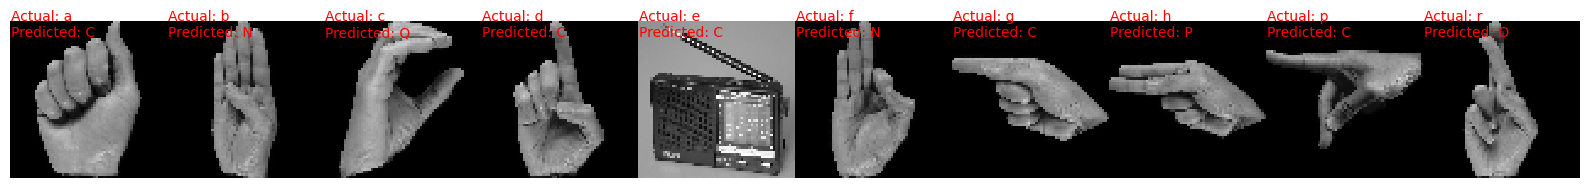

In [98]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def interact_with_user(model, letters):
    image_dir = 'Dataset2/evaluation1'
    class_folders = sorted(os.listdir(image_dir))

    plt.figure(figsize=(16, 4))  # Adjust the figure size as needed for a single row

    image_row = []  # To store images in the current row
    labels = []     # To store labels for images

    for i, folder in enumerate(class_folders):
        class_path = os.path.join(image_dir, folder)
        image_files = os.listdir(class_path)

        for j, image_file in enumerate(image_files):
            image_path = os.path.join(class_path, image_file)

            img = load_img(image_path, color_mode='grayscale', target_size=(64, 64))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            actual_class = folder
            predicted_class = letters[np.argmax(model2.predict(img_array))]

            image_row.append(np.squeeze(img_array))
            labels.append(f"Actual: {actual_class}\nPredicted: {predicted_class}")

    # Concatenate the images horizontally
    combined_image = np.concatenate(image_row, axis=1)

    plt.imshow(combined_image, cmap='gray', interpolation='none')
    plt.axis('off')

    # Annotate images with labels above them
    for i, label in enumerate(labels):
        col_idx = i * 64  # Adjust the x-coordinate based on the position within the row
        plt.text(col_idx, -5, label, fontsize=10, color='red', verticalalignment='top')

    plt.tight_layout()
    plt.show()

# Interact with the user and display all images in a single row with labels
interact_with_user(model2, letters)

This is a disaster. Not even a single prediction is right. Lets try my own phots!

1/1 [==============================] - 0s 21ms/step


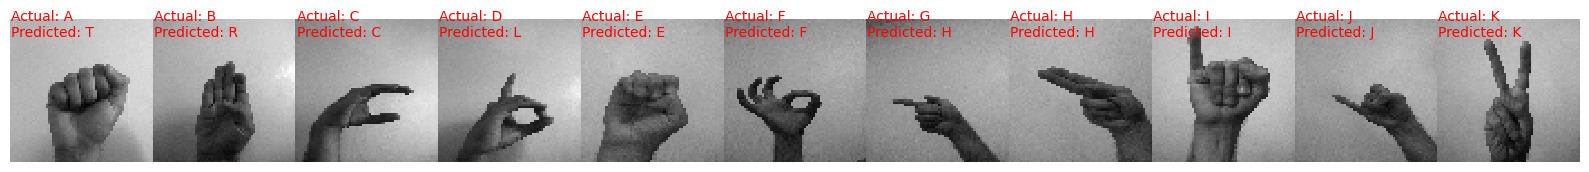

In [102]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def interact_with_user(model, letters):
    image_dir = 'Dataset2/evaluation2'
    class_folders = sorted(os.listdir(image_dir))

    plt.figure(figsize=(16, 4))  # Adjust the figure size as needed for a single row

    image_row = []  # To store images in the current row
    labels = []     # To store labels for images

    for i, folder in enumerate(class_folders):
        class_path = os.path.join(image_dir, folder)
        image_files = os.listdir(class_path)

        for j, image_file in enumerate(image_files):
            image_path = os.path.join(class_path, image_file)

            img = load_img(image_path, color_mode='grayscale', target_size=(64, 64))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            actual_class = folder
            predicted_class = letters[np.argmax(model2.predict(img_array))]

            image_row.append(np.squeeze(img_array))
            labels.append(f"Actual: {actual_class}\nPredicted: {predicted_class}")

    # Concatenate the images horizontally
    combined_image = np.concatenate(image_row, axis=1)

    plt.imshow(combined_image, cmap='gray', interpolation='none')
    plt.axis('off')

    # Annotate images with labels above them
    for i, label in enumerate(labels):
        col_idx = i * 64  # Adjust the x-coordinate based on the position within the row
        plt.text(col_idx, -5, label, fontsize=10, color='red', verticalalignment='top')

    plt.tight_layout()
    plt.show()

# Interact with the user and display all images in a single row with labels
interact_with_user(model2, letters)

This is actually pretty good. 7/11 right predictions. I am going to try another model with 7 epochs and see what happens.

In [103]:
# Build your model as before
model3 = Sequential()

model3.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model3.add(MaxPooling2D((2, 2)))

model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))

model3.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))

model3.add(Flatten())

model3.add(Dense(1024, activation='relu'))
model3.add(Dense(512, activation='relu'))
model3.add(Dense(len(letters), activation='softmax'))

# Compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [106]:
# Train the model
history3 = model3.fit(x_train, y_train, epochs=7, batch_size=64, validation_data=(x_val, y_val))

# Evaluate the model on the test set
test_loss1, test_accuracy1 = model3.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy1}")

# Save the model

model3.save('model3.h5')

Epoch 1/7
975/975 [==============================] - 389s 398ms/step - loss: 0.2291 - accuracy: 0.9236 - val_loss: 0.0837 - val_accuracy: 0.9777
Epoch 2/7
975/975 [==============================] - 383s 393ms/step - loss: 0.0756 - accuracy: 0.9766 - val_loss: 0.0368 - val_accuracy: 0.9890
Epoch 3/7
975/975 [==============================] - 377s 387ms/step - loss: 0.0399 - accuracy: 0.9878 - val_loss: 0.0401 - val_accuracy: 0.9885
Epoch 4/7
975/975 [==============================] - 379s 389ms/step - loss: 0.0338 - accuracy: 0.9906 - val_loss: 0.0386 - val_accuracy: 0.9871
Epoch 5/7
975/975 [==============================] - 388s 398ms/step - loss: 0.0295 - accuracy: 0.9914 - val_loss: 0.1471 - val_accuracy: 0.9546
Epoch 6/7
975/975 [==============================] - 385s 395ms/step - loss: 0.0340 - accuracy: 0.9904 - val_loss: 0.0524 - val_accuracy: 0.9853
Epoch 7/7
244/244 [==============================] - 15s 61ms/step - loss: 0.0037 - accuracy: 0.9988
Test Accuracy: 0.998846173286

c:\Users\Ronny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


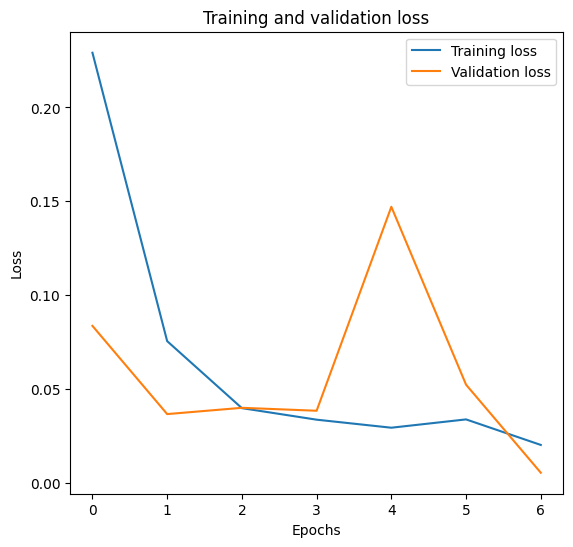

In [108]:
# Plot training and validation loss (same as before)
plt.figure(figsize=(14, 6), facecolor='w')
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss: 0.0204 - accuracy: 0.9947 - val_loss: 0.0056 - val_accuracy: 0.9985

Test Accuracy: 0.998846173286438 This is the best test accuracy so far. 
The spike from the 3rd epoch to the fifth is weird. Lets see how it predicts on other datasets

1/1 [==============================] - 0s 22ms/step


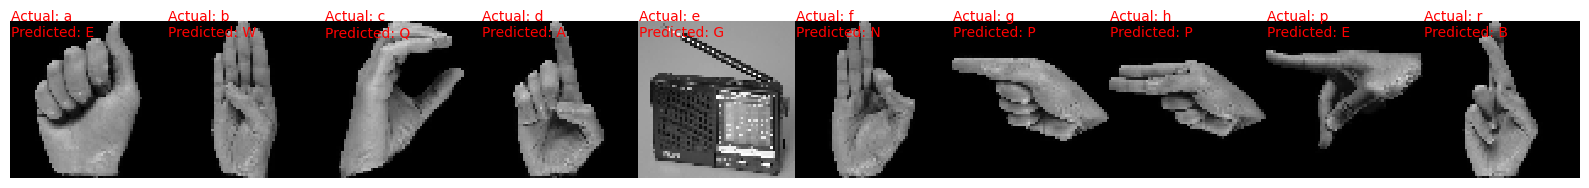

In [109]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def interact_with_user(model, letters):
    image_dir = 'Dataset2/evaluation1'
    class_folders = sorted(os.listdir(image_dir))

    plt.figure(figsize=(16, 4))  # Adjust the figure size as needed for a single row

    image_row = []  # To store images in the current row
    labels = []     # To store labels for images

    for i, folder in enumerate(class_folders):
        class_path = os.path.join(image_dir, folder)
        image_files = os.listdir(class_path)

        for j, image_file in enumerate(image_files):
            image_path = os.path.join(class_path, image_file)

            img = load_img(image_path, color_mode='grayscale', target_size=(64, 64))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            actual_class = folder
            predicted_class = letters[np.argmax(model3.predict(img_array))]

            image_row.append(np.squeeze(img_array))
            labels.append(f"Actual: {actual_class}\nPredicted: {predicted_class}")

    # Concatenate the images horizontally
    combined_image = np.concatenate(image_row, axis=1)

    plt.imshow(combined_image, cmap='gray', interpolation='none')
    plt.axis('off')

    # Annotate images with labels above them
    for i, label in enumerate(labels):
        col_idx = i * 64  # Adjust the x-coordinate based on the position within the row
        plt.text(col_idx, -5, label, fontsize=10, color='red', verticalalignment='top')

    plt.tight_layout()
    plt.show()

# Interact with the user and display all images in a single row with labels
interact_with_user(model3, letters)

Disaster... Not even one right prediction. Lets try my own photos.

1/1 [==============================] - 0s 21ms/step


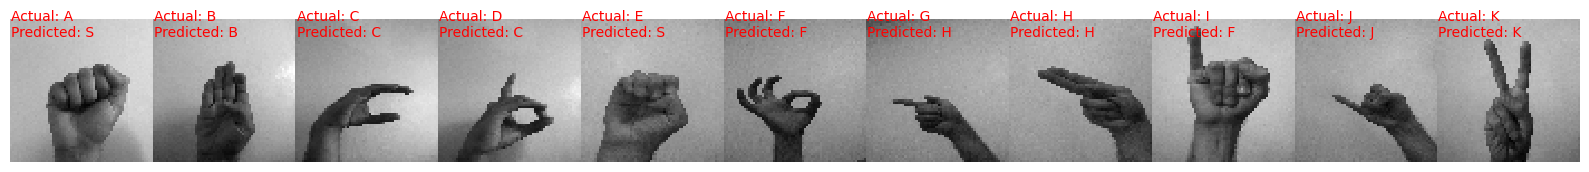

In [110]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def interact_with_user(model, letters):
    image_dir = 'Dataset2/evaluation2'
    class_folders = sorted(os.listdir(image_dir))

    plt.figure(figsize=(16, 4))  # Adjust the figure size as needed for a single row

    image_row = []  # To store images in the current row
    labels = []     # To store labels for images

    for i, folder in enumerate(class_folders):
        class_path = os.path.join(image_dir, folder)
        image_files = os.listdir(class_path)

        for j, image_file in enumerate(image_files):
            image_path = os.path.join(class_path, image_file)

            img = load_img(image_path, color_mode='grayscale', target_size=(64, 64))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            actual_class = folder
            predicted_class = letters[np.argmax(model3.predict(img_array))]

            image_row.append(np.squeeze(img_array))
            labels.append(f"Actual: {actual_class}\nPredicted: {predicted_class}")

    # Concatenate the images horizontally
    combined_image = np.concatenate(image_row, axis=1)

    plt.imshow(combined_image, cmap='gray', interpolation='none')
    plt.axis('off')

    # Annotate images with labels above them
    for i, label in enumerate(labels):
        col_idx = i * 64  # Adjust the x-coordinate based on the position within the row
        plt.text(col_idx, -5, label, fontsize=10, color='red', verticalalignment='top')

    plt.tight_layout()
    plt.show()

# Interact with the user and display all images in a single row with labels
interact_with_user(model3, letters)

6 / 11 right predictions. The previous model is the best one so far. 

Lets try one last model. I want to try a pretrained model, save the CNN with weights and biases and then train a new model with the pretrained model as a base.
I am going to use VGG16. 

This model wants coloured pictures as input so from now on we have to deal with colours. Before we go and train the model I just want to see the original images versus
the preprocessed images in colour and see how it looks.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


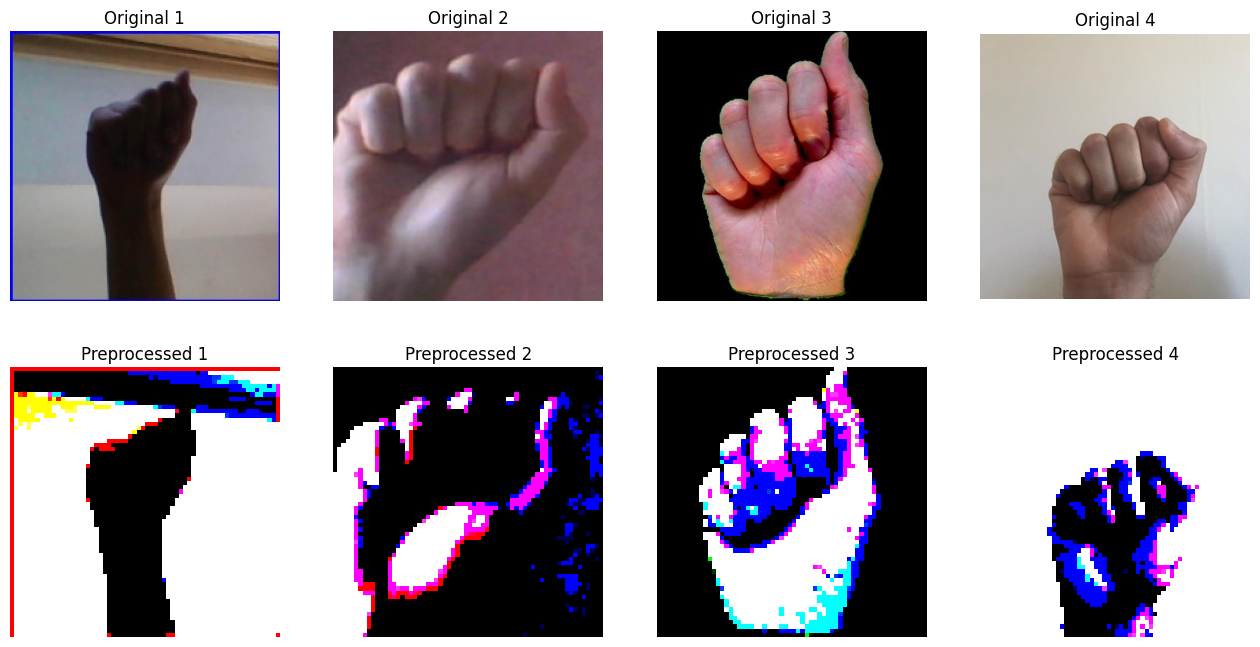

In [116]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

IMG_SIZE = (64, 64)  # Default input size for VGG16
# Specify the path to the "Image_choice" directory containing four pictures
IMAGE_CHOICE_PATH = "Image_choice"

# Get a list of image file names in the directory
image_file_names = os.listdir(IMAGE_CHOICE_PATH)

# Create the full paths to the images
image_paths = [os.path.join(IMAGE_CHOICE_PATH, name) for name in image_file_names]

# Function to preprocess an image
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=IMG_SIZE, color_mode='rgb'
    )
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

# Load and preprocess the original and preprocessed images
original_images = [tf.keras.preprocessing.image.load_img(path) for path in image_paths]
preprocessed_images = [preprocess_image(path) for path in image_paths]

# Create labels for the images
labels = ["Original 1", "Original 2", "Original 3", "Original 4",
          "Preprocessed 1", "Preprocessed 2", "Preprocessed 3", "Preprocessed 4"]

# Plot the images with labels
plt.figure(figsize=(16, 8))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(original_images[i] if i < 4 else preprocessed_images[i - 4])
    plt.title(labels[i])
    plt.axis("off")

plt.show()

The first preprocessed picture is not very good. The wooden board in the background becomes very clear and significant when we preprocess the picture and that is not a good thing.
It even blends together with our hand so the filter in our CNN that looks for edges is going to send alot of features we dont want as input to our classification layer.
The thing we are after here is to isolate the hand from everything else and search for a very clean background.

The second picture looks even worse. The lines here is not drawing a complete hand but only parts of it. This is not going to give our model good features for detecting sign lanugage.

The thrid hand is very good. I think this is because the background is artificially made black so it is a very good significant boundary between our hand and the background.

The fourth picture is my own picture and it looks pretty good too. I only have 7 pictures of my own pictures so I am only going to use them as evaluation pictures to make predictions
on with our final model.

I am going to use the third dataset for training, testing and validation. Then I am going to use my own pictures and maybe some other pictures from the other datasets to try and 
make predictions on.


# Preprocessing

The preprocessing is pretty much the same in this one but we have colour in our pictures now. 64x64 pixel, split the data into train, test, validation.
Then we use some augmentation to reduce the chance of overfitting

In [119]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Specify the path to your custom dataset directory
CUSTOM_DATASET_PATH = "Dataset2/asl_dataset"

# Create a list of class names (A-Z)
class_names = sorted(os.listdir(CUSTOM_DATASET_PATH))

# Setting up variables
BATCH_SIZE = 32
IMG_SIZE = (64, 64)

# Importing the dataset and splitting it into training, validation, and test sets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    CUSTOM_DATASET_PATH,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # 20% for validation
    subset="training",
    seed=123,  # Add a seed for consistent data split
    color_mode="rgb"  # Load images as RGB
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    CUSTOM_DATASET_PATH,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # 20% for validation
    subset="validation",
    seed=123,  # Use the same seed for consistent data split
    color_mode="rgb"  # Load images as RGB
)

# Split the validation dataset into validation and test datasets (50% each)
validation_size = len(validation_dataset)
test_size = validation_size // 2
validation_dataset = validation_dataset.skip(test_size)
test_dataset = validation_dataset.take(test_size)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

# Create the base model VGG16 with pre-trained weights (include_top=False for feature extraction)
base_model = tf.keras.applications.VGG16(
    input_shape=IMG_SIZE + (3,),  # Input shape with 3 channels (RGB)
    include_top=False,
    weights='imagenet'
)

# Freeze the layers of the pre-trained model
base_model.trainable = False

# Add custom layers for classification
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(class_names))

# Build the final model by chaining layers
model4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=IMG_SIZE + (3,)),  # Input shape for RGB images
    data_augmentation,
    base_model,
    global_average_layer,
    prediction_layer
])

# Compile the model
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Found 1815 files belonging to 26 classes.
Using 1452 files for training.
Found 1815 files belonging to 26 classes.
Using 363 files for validation.


Train the model

In [120]:
# Train the model
epochs = 10 

history4 = model4.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

# Save the trained model to a file
model4.save("trained_model.h5")

Epoch 1/10


46/46 [==============================] - 18s 373ms/step - loss: 11.1147 - accuracy: 0.1295 - val_loss: 7.9501 - val_accuracy: 0.1871
Epoch 2/10
46/46 [==============================] - 17s 373ms/step - loss: 4.9475 - accuracy: 0.3512 - val_loss: 4.1718 - val_accuracy: 0.3509
Epoch 3/10
46/46 [==============================] - 18s 381ms/step - loss: 3.2122 - accuracy: 0.4800 - val_loss: 3.0293 - val_accuracy: 0.4444
Epoch 4/10
46/46 [==============================] - 18s 387ms/step - loss: 2.2426 - accuracy: 0.5613 - val_loss: 2.1694 - val_accuracy: 0.5614
Epoch 5/10
46/46 [==============================] - 18s 393ms/step - loss: 1.6268 - accuracy: 0.6481 - val_loss: 1.8211 - val_accuracy: 0.6257
Epoch 6/10
46/46 [==============================] - 18s 393ms/step - loss: 1.3597 - accuracy: 0.6860 - val_loss: 1.6404 - val_accuracy: 0.6257
Epoch 7/10
46/46 [==============================] - 18s 396ms/step - loss: 1.2453 - accuracy: 0.7176 - val_loss: 1.2576 - val_accuracy: 0.6725
Epoch 8/1

c:\Users\Ronny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [121]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model4.evaluate(test_dataset)

# Print the test accuracy
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

6/6 [==============================] - 2s 292ms/step - loss: 1.2873 - accuracy: 0.6959
Test accuracy: 69.59%


Test accuracy is quite bad and the loss is high.

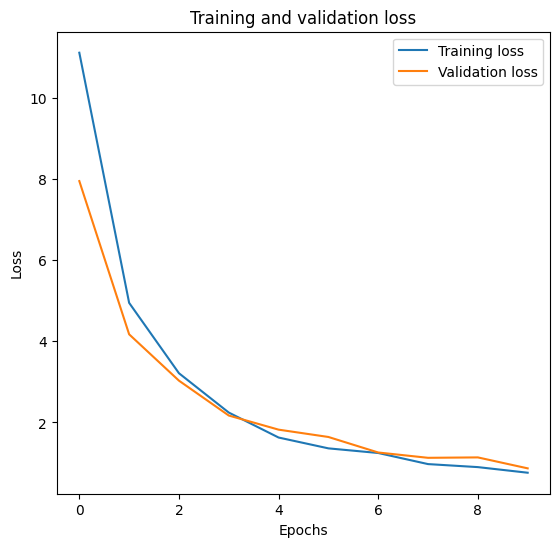

In [122]:
# Plot training and validation loss (same as before)
plt.figure(figsize=(14, 6), facecolor='w')
plt.subplot(1, 2, 1)
plt.plot(history4.history['loss'], label='Training loss')
plt.plot(history4.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

This looks really good though. The curves follow eachother really well. Lets try predict on other datasets

1/1 [==============================] - 0s 36ms/step


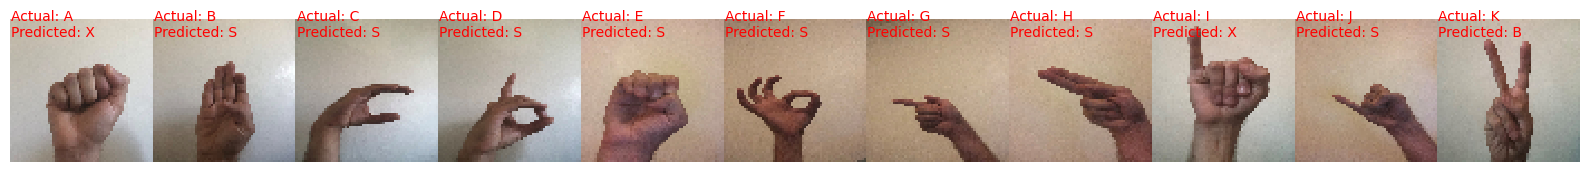

In [126]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def interact_with_user(model, letters):
    image_dir = 'Dataset2/evaluation2'
    class_folders = sorted(os.listdir(image_dir))

    plt.figure(figsize=(16, 4))  # Adjust the figure size as needed for a single row

    image_row = []  # To store images in the current row
    labels = []     # To store labels for images

    for i, folder in enumerate(class_folders):
        class_path = os.path.join(image_dir, folder)
        image_files = os.listdir(class_path)

        for j, image_file in enumerate(image_files):
            image_path = os.path.join(class_path, image_file)

            img = load_img(image_path, color_mode='rgb', target_size=(64, 64))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            actual_class = folder
            predicted_class = letters[np.argmax(model4.predict(img_array))]

            image_row.append(np.squeeze(img_array))
            labels.append(f"Actual: {actual_class}\nPredicted: {predicted_class}")

    # Concatenate the images horizontally
    combined_image = np.concatenate(image_row, axis=1)

    plt.imshow(combined_image, cmap='gray', interpolation='none')
    plt.axis('off')

    # Annotate images with labels above them
    for i, label in enumerate(labels):
        col_idx = i * 64  # Adjust the x-coordinate based on the position within the row
        plt.text(col_idx, -5, label, fontsize=10, color='red', verticalalignment='top')

    plt.tight_layout()
    plt.show()

# Interact with the user and display all images in a single row with labels
interact_with_user(model4, letters)

Horrible results. Not even one right prediction. One last time i am going to choose the other dataset and train it.

In [127]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Specify the path to your custom dataset directory
CUSTOM_DATASET_PATH = "Dataset/sign_train"

# Create a list of class names (A-Z)
class_names = sorted(os.listdir(CUSTOM_DATASET_PATH))

# Setting up variables
BATCH_SIZE = 32
IMG_SIZE = (64, 64)

# Importing the dataset and splitting it into training, validation, and test sets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    CUSTOM_DATASET_PATH,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # 20% for validation
    subset="training",
    seed=123,  # Add a seed for consistent data split
    color_mode="rgb"  # Load images as RGB
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    CUSTOM_DATASET_PATH,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,  # 20% for validation
    subset="validation",
    seed=123,  # Use the same seed for consistent data split
    color_mode="rgb"  # Load images as RGB
)

# Split the validation dataset into validation and test datasets (50% each)
validation_size = len(validation_dataset)
test_size = validation_size // 2
validation_dataset = validation_dataset.skip(test_size)
test_dataset = validation_dataset.take(test_size)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

# Create the base model VGG16 with pre-trained weights (include_top=False for feature extraction)
base_model = tf.keras.applications.VGG16(
    input_shape=IMG_SIZE + (3,),  # Input shape with 3 channels (RGB)
    include_top=False,
    weights='imagenet'
)

# Freeze the layers of the pre-trained model
base_model.trainable = False

# Add custom layers for classification
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(class_names))

# Build the final model by chaining layers
model5 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=IMG_SIZE + (3,)),  # Input shape for RGB images
    data_augmentation,
    base_model,
    global_average_layer,
    prediction_layer
])

# Compile the model
model5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Found 78000 files belonging to 26 classes.
Using 62400 files for training.
Found 78000 files belonging to 26 classes.
Using 15600 files for validation.


In [128]:
# Train the model
epochs = 10 

history5 = model5.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

# Save the trained model to a file
model5.save("trained_model.h5")

Epoch 1/10
1950/1950 [==============================] - 943s 483ms/step - loss: 3.8959 - accuracy: 0.4567 - val_loss: 2.0705 - val_accuracy: 0.5714
Epoch 2/10
1950/1950 [==============================] - 824s 422ms/step - loss: 1.5464 - accuracy: 0.6277 - val_loss: 1.6700 - val_accuracy: 0.6471
Epoch 3/10
1950/1950 [==============================] - 849s 435ms/step - loss: 1.3838 - accuracy: 0.6577 - val_loss: 1.6490 - val_accuracy: 0.6417
Epoch 4/10
1950/1950 [==============================] - 856s 439ms/step - loss: 1.3708 - accuracy: 0.6646 - val_loss: 1.6171 - val_accuracy: 0.6541
Epoch 5/10
1950/1950 [==============================] - 853s 437ms/step - loss: 1.3633 - accuracy: 0.6722 - val_loss: 1.7067 - val_accuracy: 0.6520
Epoch 6/10
1950/1950 [==============================] - 832s 427ms/step - loss: 1.3707 - accuracy: 0.6742 - val_loss: 1.8751 - val_accuracy: 0.6502
Epoch 7/10
1950/1950 [==============================] - 797s 409ms/step - loss: 1.3863 - accuracy: 0.6761 - val_

c:\Users\Ronny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [129]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model5.evaluate(test_dataset)

# Print the test accuracy
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

244/244 [==============================] - 83s 335ms/step - loss: 1.9814 - accuracy: 0.6416
Test accuracy: 64.16%


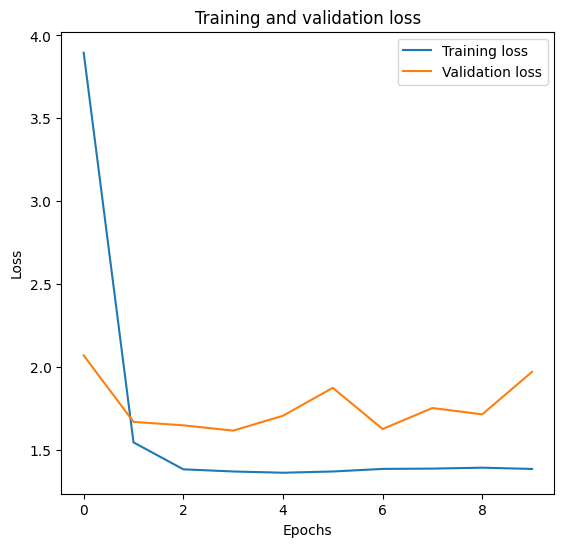

In [130]:
# Plot training and validation loss (same as before)
plt.figure(figsize=(14, 6), facecolor='w')
plt.subplot(1, 2, 1)
plt.plot(history5.history['loss'], label='Training loss')
plt.plot(history5.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test accuracy: 64.16%

loss: 1.3860 - accuracy: 0.6796 - val_loss: 1.9718 - val_accuracy: 0.6431

This is the worst model so far. It looks like the model is doing very bad at generalizing. The training loss is far too high so the validation data becomes even higher. 
It really seems to fail grabbing the right features from my pictures. I think the coulours really messed things up for this model. Im not even going to try and predict
with this garbage model.

# Summary

## The dataset

I realized how important it is to view and evaluate the pictures in the dataset before even considering using them.
Depending on what you want to do you have to really think about how difficult it is going to be to get relevant
features out of it. Here I wanted something very simple : 

A one coloured background
As few shadows as possible
Every sign from an angle where it really made that sign unique in realtion to the others

This could be easily achieved by drawing pictures in paint. Then you could arrange the whole picture yourself.
But that would mean that it would be customized for this particular model for this specific task. I wanted to
try to build a more generalized model that could predict sign lanugage in other datasets. I wanted to work with
pictures instead of digital art 

## The preprocessing

There was a huge difference for the model to learning to generalize depending how the pictures were preprocessed.
We could see on the plot where I compared 64x64 and the 32x32 that there was a huge dirrence in how the lines 
around the hand was drawn. The 64x64 was way smoother and sharper than the 32x32 ones.
The coloured images became way more complex to generalize. There we could see on the photos that things in
the background became way more visible than before the preprocessing and the brightness of the whole picture
was traded for a much darker picture. The shadows in the hand ruined the whole picture by making the shadows in
the hand blend together with the background and making it impossible for the CNN filter to find good features
that represented a hand at all. 

## The model

First Im building some simple models myself with eight layers, three convolutional layers (64, 128, and 256 filters), three max pooling layers and two Dense layers. 
Those models got pretty hight test accuracy, no overfitting and quite low loss. 

First model : 

32x32 Image size
0.16: loss
accuracy: 0.9986 
val_loss: 0.0393
val_accuracy: 0.9890
0.9670329689979553
Accurate predictions on my own pictures : 0/11


Second model
0.005 loss with 64x64 Image size so the bigger 
the image size the more accurate it was. 
loss: 0.014
accuracy: 0.99
val_loss: 0.07
val_accuracy: 0.97
Test_accuracy : 0.97
Accurate predictions on my own pictures : 7/11

Third model with VGG16 :

Image size : 64x64
loss: 0.7591
accuracy: 0.7996
val_loss: 0.8668
val_accuracy: 0.7661
test_accuracy : 0.69
Accurate predictions on my own pictures : 0/11

Fourth model : 

loss: 1.3860
accuracy: 0.6796
val_loss: 1.9718
val_accuracy: 0.6431
test_accuracy : 0.64


